# Business Problem:



AutoVehicle is a leading self-driving car manufacturing company that is committed to ensuring the safety of its autonomous vehicles on the road. To achieve this goal, the company has developed a proprietary dataset that contains images of objects on the road, captured by the sensors on its autonomous vehicles while customers are driving the cars.

AutoVehicle has hired a team of data scientists to build a machine learning model that can accurately detect hazardous and non-hazardous vehicles on the road using this proprietary dataset. The team of data scientists includes Boise, Mellisa, and Jeevan, who are all experts in the field of computer vision and deep learning.

The team began by exploring the proprietary dataset and performing various preprocessing steps to clean and prepare the data for training. Once the dataset was preprocessed, the team used ML models to train a machine learning model that could accurately detect hazardous and non-hazardous vehicles on the road. 

After several hours of training the model, the team achieved high accuracy on the validation set. The model was then deployed in a production environment, where it was able to detect hazardous and non-hazardous vehicles on the road in real-time.

AutoVehicle was thrilled with the results of the machine learning model, as it significantly improved the safety of its autonomous vehicles on the road. The company's customers were also pleased with the increased safety features of the self-driving cars, which helped to boost customer satisfaction and loyalty.





# Importance of reliable hazardous object detection for self-driving cars

Reliable hazardous object detection is a critical component of self-driving cars, as it plays a crucial role in ensuring the safety of autonomous vehicles on the road. Hazardous objects such as other cars, trucks etc can be detected using a variety of sensors such as cameras and passed to the object detection models to identify the objects. In this project, we will use a pre-trained object detection model to detect hazardous objects in images.

In [1]:
import numpy as np
import gdown
import PIL 
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt
from glob import glob
import random
import cv2
import warnings
import ultralytics
import os
from ultralytics import YOLO
import zipfile
import pandas as pd
warnings.simplefilter('ignore')
import numpy as np
import cv2
import csv
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

In [2]:
# Function to create directories if they do not exist
def create_directories(path):
    print("Path is: ", path)
    if not os.path.exists(path):
        os.makedirs(path)

# Load the model
yolo_model = YOLO('yolov8m.pt')

In [3]:
# Set the project root directory
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Set the download directory to data/downloaded_images
download_directory = os.path.join(project_root, 'data', 'downloaded_images')
zip_path = os.path.join(download_directory, 'images.zip')
googldrive_url = 'https://drive.google.com/uc?id=179DFjTRrYNi2h9Umxei4uXeqEsg19Lvh'

# check if the directory exists
if not os.path.exists(download_directory):
    # Create the directory
    create_directories(download_directory)
    print("Directory created")
    # Download the images
    gdown.download(googldrive_url, zip_path, quiet=False)
else:
    print("Directory already exists so skipping download")

Directory already exists so skipping download


Images directory already exists so skipping extraction


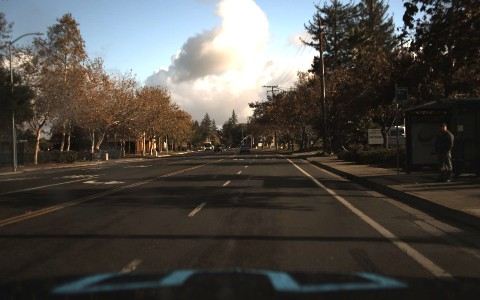

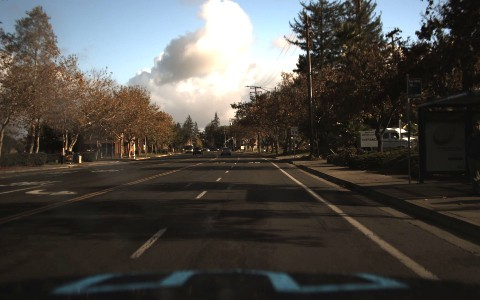

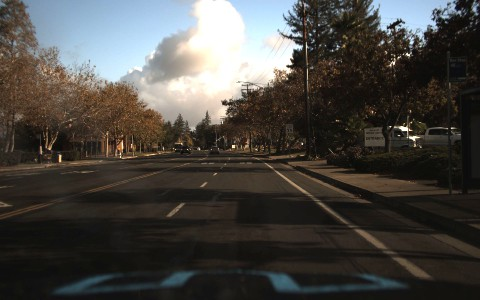

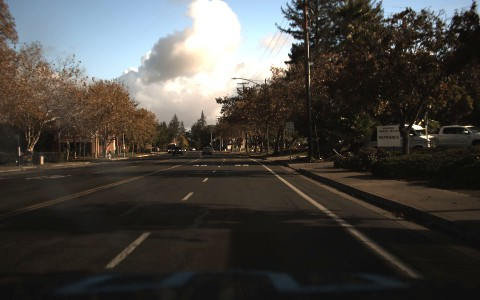

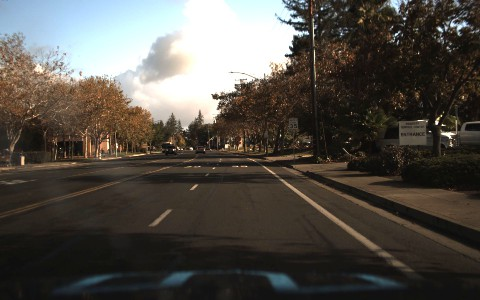

In [4]:
# Check if the images directory exists
if not os.path.exists(os.path.join(download_directory, 'images')):
    # Extract the images
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(download_directory)
else:
    print("Images directory already exists so skipping extraction")

# Optional: Display some images to verify that the images were downloaded correctly
image_files = glob(os.path.join(download_directory, 'images', '*.jpg'))  # Adjust file extension as needed

#image_files = glob(os.path.join(download_directory, '*.jpg'))  # Adjust file extension as needed
for i in range(min(5, len(image_files))):  # Display up to 5 images
    img = Image.open(image_files[i])
    display(img)

# Data Understanding


The dataset is divided into two categories: training and validation. 

The training dataset consists of 18,000 unique images, and the validation dataset consists of 4,241 distinct images. On average, each image in the validation dataset contains seven objects, each belonging to one of five classes: Car, Truck, Pedestrian, Bicycle, and Traffic Light.

For each image in the training dataset, the bounding box coordinates of the object(s) present in the image are provided in the format of (xmin, xmax, ymin, ymax). These coordinates are used to draw the bounding box around the object in the image, which defines the region of interest around the object and is essential for object detection and localization.

The validation dataset provides a separate set of images that can be used to evaluate the performance of the machine learning model. The goal is to develop a model that can accurately detect and classify objects in new, unseen images, which is essential for the safe and reliable operation of autonomous vehicles on the road. The bounding box coordinates provided in the dataset enable the creation of comprehensive object detection algorithms that can detect and avoid potential hazards on the road.




In [5]:
# Define the path to the labels file  
labels_file = os.path.join(project_root, 'data', 'labels.csv')  
  
# Read the labels file into a pandas dataframe  
df = pd.read_csv(labels_file)

df.head()

frame  xmin  xmax  ymin  ymax  class_id
0  1478019952686311006.jpg   237   251   143   155         1
1  1478019952686311006.jpg   437   454   120   186         3
2  1478019953180167674.jpg   218   231   146   158         1
3  1478019953689774621.jpg   171   182   141   154         2
4  1478019953689774621.jpg   179   191   144   155         1

In [6]:
# Number of distinct images in the dataset
print('Number of distinct images in the dataset:', len(df['frame'].unique()))  
  
# Number of distinct classes in the dataset
print('Number of distinct classes in the dataset:', len(df['class_id'].unique()))  
  
# List of different classes in the dataset
print('List of different classes:', df['class_id'].unique())  
  
# Average number of objects in each image  
print('Average number of objects in each image:', round(df.groupby('frame').size().mean()))
  
# Validation Dataset
labels_file_val = os.path.join(project_root, 'data', 'labels_val.csv')  
  
# Read the validation labels file into a pandas dataframe  
df_val = pd.read_csv(labels_file_val)  
  
# Number of distinct images in the validation dataset
print('Number of distinct images in the validation dataset:', len(df_val['frame'].unique()))  
  
# Number of distinct classes in the validation dataset
print('Number of distinct classes in the validation dataset:', len(df_val['class_id'].unique()))  
  
# List of different classes in the validation dataset
print('List of different classes in the validation dataset:', df_val['class_id'].unique())  
  
# Average number of objects in each image in the validation dataset
print('Average number of objects in each image:', round(df_val.groupby('frame').size().mean()))


Number of distinct images in the dataset: 18000
Number of distinct classes in the dataset: 5
List of different classes: [1 3 2 5 4]
Average number of objects in each image: 7
Number of distinct images in the validation dataset: 4241
Number of distinct classes in the validation dataset: 5
List of different classes in the validation dataset: [5 1 2 3 4]
Average number of objects in each image: 8


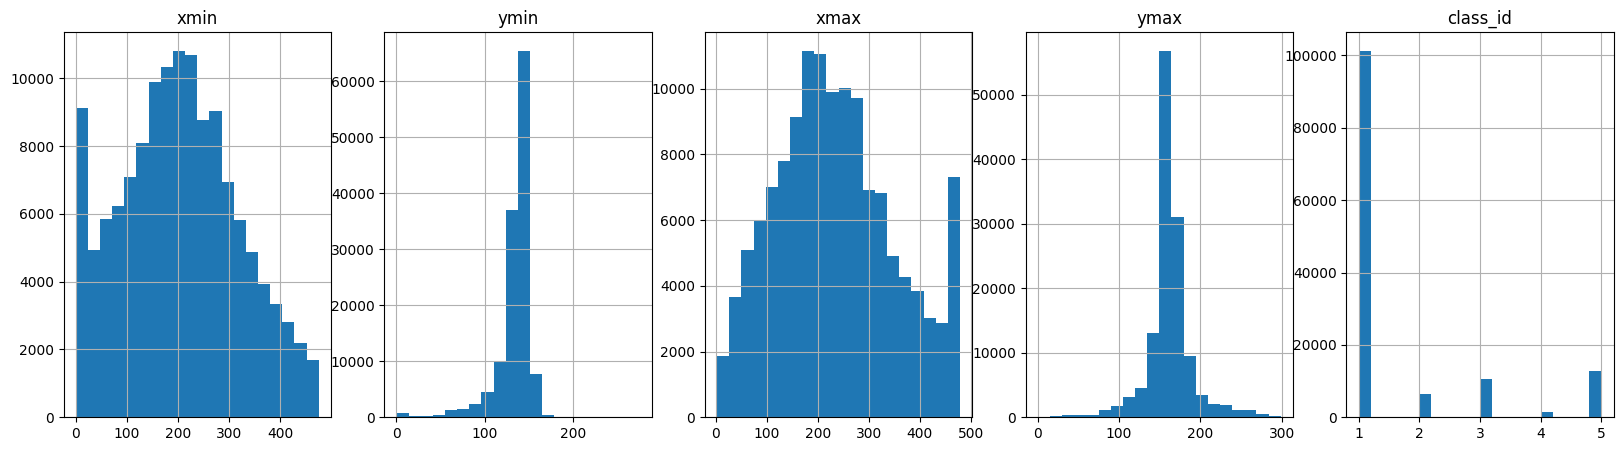

In [7]:
# Plot the distribution of the bounding box coordinates and class_id
fig, axs = plt.subplots(1, 5, figsize=(20, 5))
df['xmin'].hist(ax=axs[0], bins=20)
axs[0].set_title('xmin')
df['ymin'].hist(ax=axs[1], bins=20)
axs[1].set_title('ymin')
df['xmax'].hist(ax=axs[2], bins=20)
axs[2].set_title('xmax')
df['ymax'].hist(ax=axs[3], bins=20)
axs[3].set_title('ymax')
df['class_id'].hist(ax=axs[4], bins=20)
axs[4].set_title('class_id')
plt.show()

We can see data is imbalance label 1 is more than 2, 3, 4, 5. 


# EDA on the data

In [8]:
# Get the number of images
num_images = len(image_files)
print("Number of images: ", num_images)

Number of images:  22241


## Check the number of Channels in the image

In [9]:
# Get the image shapes
for i in range(min(5, len(image_files))):
    img = Image.open(image_files[i])
    print("Image shape: ", np.array(img).shape)

Image shape:  (300, 480, 3)
Image shape:  (300, 480, 3)
Image shape:  (300, 480, 3)
Image shape:  (300, 480, 3)
Image shape:  (300, 480, 3)


In [10]:
image_channels = np.array(img).shape[2]
print("The number of channels in the image is: ", image_channels)

# Get Height and Width of the image for the first image
image_height = np.array(img).shape[0]
image_width = np.array(img).shape[1]
print("The height of the image is: ", image_height)
print("The width of the image is: ", image_width)

The number of channels in the image is:  3
The height of the image is:  300
The width of the image is:  480


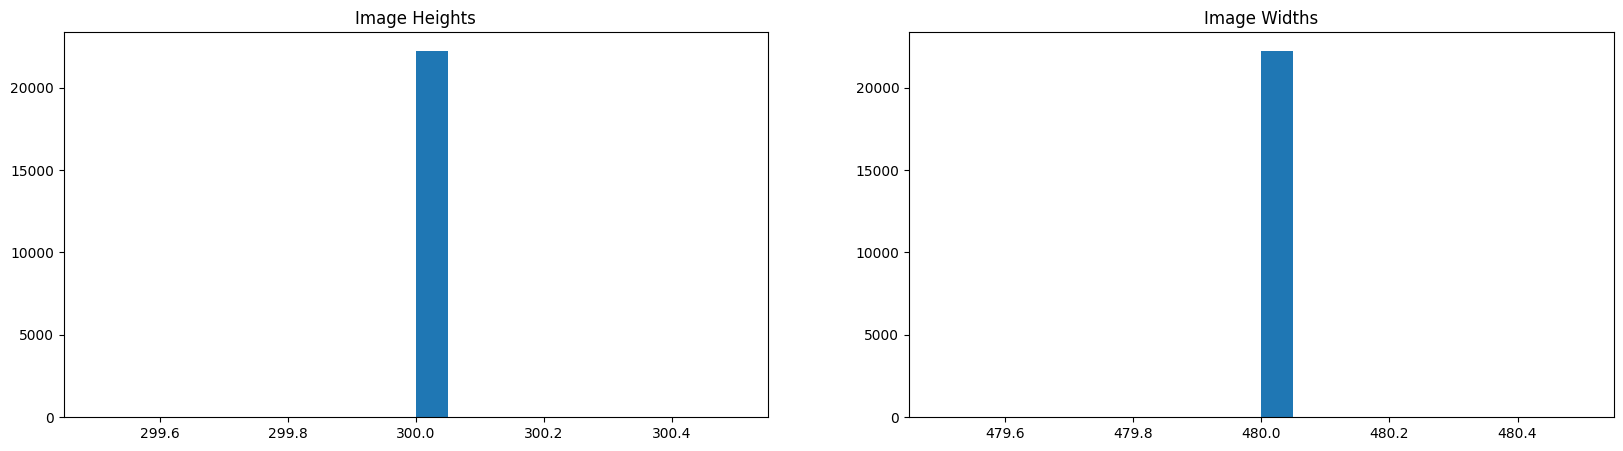

In [11]:
# Plot the image sizes
# Get the image sizes
image_sizes = []
for i in range(len(image_files)):
    img = Image.open(image_files[i])
    image_sizes.append(np.array(img).shape[:2])

# Get the aspect ratios
aspect_ratios = [size[0] / size[1] for size in image_sizes]

# Plot the image sizes
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
axs[0].hist([size[0] for size in image_sizes], bins=20)
axs[0].set_title('Image Heights')
axs[1].hist([size[1] for size in image_sizes], bins=20)
axs[1].set_title('Image Widths')
plt.show()


Based on the results all the 18000 image have same size 300.0 and width 480. It is better to resize the images to 416x416


In [12]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=3, draw_dot=False, radius=7):
    ''' 
    This function draws out the bounding boxes for objects in the image as
    specified by the csv file
    '''
    # Make a copy of the image
    draw_img = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(draw_img, tuple(bbox[0]), tuple(bbox[1]), color, thick)
        if draw_dot:
            centre = (np.array(bbox[0]) + np.array(bbox[1])) // 2
            cv2.circle(draw_img, tuple(centre), radius=radius, color=(0, 255, 0), thickness=-1)
    # Return the image copy with boxes drawn
    return draw_img

def draw_grid(img, grid=11, thick=3):
    '''
    Visualize gridcells over the given image
    '''
    x, y = img.shape[1], img.shape[0]
    x_inc, y_inc = x//grid, y//grid
    
    for a in range(grid):
        cv2.line(img, (a*x_inc, 0), (a*x_inc, y), color=(255,0,0), thickness=thick)
    for b in range(grid):
        cv2.line(img, (0, b*y_inc), (x, b*y_inc), color=(255,0,0), thickness=thick)
    return img

def frame_dict(labels_rows, scalex=1, scaley=1):
    frames = {}
    for row in labels_rows[1:] :
        if str(row[4]) not in frames:
            frames[str(row[4])] = []
        frames[str(row[4])].append( ( 
            ((int(int(row[0])//scalex), int(int(row[1])//scaley)) , (int(int(row[2])//scalex), int(int(row[3])//scaley)))  ,  
            (int(row[5]=='Car'), int(row[5]=='Truck'), int(row[5]=='Pedestrian')) 
        ) )
    return frames

def label_to_tensor(frame, imgsize=(224, 224), gridsize=(11,11), classes=3, bboxes=2):
    '''
    label_to_tensor() function takes in a frame label info from the dataset and 
    returns an array of shape SS(C+5B): [ClassProb--Confidence--x/y/w/h]
    Confidence is set to zero as it needs to be calculated at training time for each BBox predicted by the classifier
    '''
    grid = np.zeros(gridsize)
    
    y_span = imgsize[0]/gridsize[0]
    x_span = imgsize[1]/gridsize[1]
    
    class_prob = np.zeros((gridsize[0], gridsize[1], classes))
    confidence = np.zeros((gridsize[0], gridsize[1], bboxes))
    dims = np.zeros((gridsize[0], gridsize[1], bboxes, 4))
    
    for box in frame:
        ((x1,y1), (x2,y2)), (c1,c2,c3) = box
        x_grid = int(((x1+x2)/2)//x_span)
        y_grid = int(((y1+y2)/2)//y_span)
        
        class_prob[y_grid, x_grid] = (c1,c2,c3)
        
        x_center = ((x1+x2)/2)
        y_center = ((y1+y2)/2)
        
        x_center_norm = (x_center-x_grid*x_span)/(x_span)
        y_center_norm = (y_center-y_grid*y_span)/(y_span)
        
        w = x2-x1
        h = y2-y1
        
        w_norm = w/imgsize[1]
        h_norm = h/imgsize[0]
        
        dims[y_grid, x_grid, :, :] = (x_center_norm, y_center_norm, w_norm, h_norm)
        
        grid[y_grid, x_grid] += 1
        
    tensor = np.concatenate((class_prob.ravel(), confidence.ravel(), dims.ravel()))
    return grid, tensor

In [92]:
def coord_translate(bboxes, tr_x, tr_y):
    '''
    Takes a singl frame's bounding box list with confidence scores and
    applies translation (addition) to the coordinates specified by 'tr'

    parameters:
    bboxes: list with element of the form ((x1,y1), (x2,y2)), (c1,c2,c3)
    tr_x, tr_y: translation factor to add the coordinates to, for x and y respectively

    returns: new list with translated coordinates and same conf scores; same shape as bboxes
    '''
    new_list = []
    for box in bboxes:
        coords = np.array(box[0])
        coords[:,0] = coords[:,0] + tr_x
        coords[:,1] = coords[:,1] + tr_y
        coords = coords.tolist()
        new_list.append((coords, box[1]))
    return new_list
def coord_scale(bboxes, sc):
    '''
    Takes a singl frame's bounding box list with confidence scores and
    applies scaling to the coordinates specified by sc

    parameters:
    bboxes: list with element of the form ((x1,y1), (x2,y2)), (c1,c2,c3)
    sc: scaling factor to multiply the coordinates with

    returns: new list with scaled coordinates and same conf scores; same shape as bboxes
    '''
    new_list = []
    for box in bboxes:
        coords = np.array(box[0])
        coords = coords * sc
        coords = coords.astype(np.int64)
        out_of_bound_indices = coords[0,:]>224
        if out_of_bound_indices.any():
            continue
        coords = coords.tolist()
        new_list.append((coords, box[1]))
    return new_list
def augument_data(label, frame, imgsize=(224, 224), folder=  os.path.join(download_directory, 'images')):
    '''
    Takes the image file name and the frame (rows corresponding to a single image in the labels.csv)
    and randomly scales, translates, adjusts SV values in HSV space for the image,
    and adjusts the coordinates in the 'frame' accordingly, to match bounding boxes in the new image
    '''
    img = cv2.imread(folder+label)
    img = cv2.resize(img, imgsize)
    rows, cols = img.shape[:2]

    #translate_factor
    tr = np.random.random() * 0.2
    tr_y = np.random.randint(rows*-tr,rows*tr)
    tr_x = np.random.randint(cols*-tr, cols*tr)
    #scale_factor
    sc = np.random.random() * 0.4 + 0.8

    # flip coin to adjust image saturation
    r = np.random.rand()
    if r < 0.5:
        #randomly adjust the S and V values in HSV representation
        img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV).astype(np.float32)
        fs = np.random.random() + 0.7
        fv = np.random.random() + 0.2
        img[:,:,1] *= fs
        img[:,:,2] *= fv
        img = img.astype(np.uint8)
        img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)
        print('adjusted SV: {}, {}'.format(fs, fv))

    # new random factor for scaling and translating
    r = np.random.rand()

    if r < 0.3:
        #translate image
        M = np.float32([[1,0,tr_x], [0,1,tr_y]])
        img = cv2.warpAffine(img, M, (cols,rows))
        frame = coord_translate(frame, tr_x, tr_y)
        print('translating by: {}, {}'.format(tr_x, tr_y))
    elif r < 0.6:
        #scale image keeping the same size
        placeholder = np.zeros_like(img)
        meta = cv2.resize(img, (0,0), fx=sc, fy=sc)
        if sc < 1:
            placeholder[:meta.shape[0], :meta.shape[1]] = meta
        else:
            placeholder = meta[:placeholder.shape[0], :placeholder.shape[1]]
        img = placeholder
        frame = coord_scale(frame, sc)
        print('scaled by: {}'.format(sc))

    return img, frame

In [13]:
# Frames dictionary to store the bounding boxes for each frame
frames = {}
for i, row in df.iterrows():
    if row['frame'] not in frames:
        frames[row['frame']] = []
    frames[row['frame']].append( ( 
        ((int(row['xmin']), int(row['ymin'])) , (int(row['xmax']), int(row['ymax'])))  ,  
        (int(row['class_id']==1), int(row['class_id']==2), int(row['class_id']==3), int(row['class_id']==4), int(row['class_id']==5))
    ))

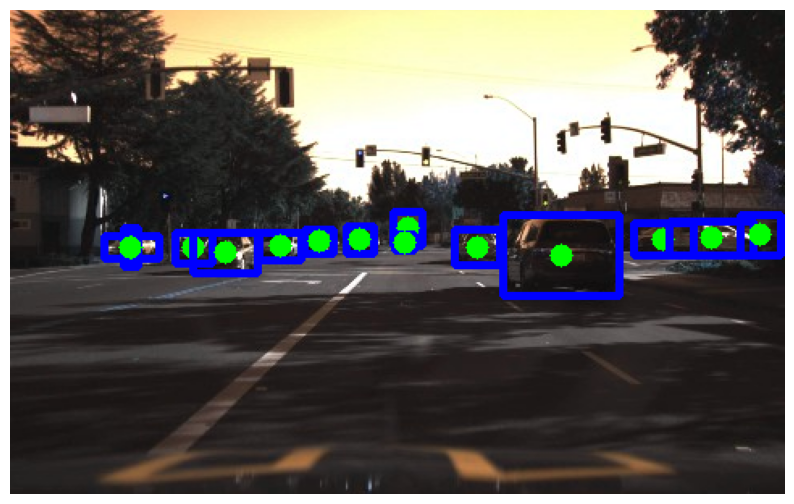

In [14]:
# Visualize the bounding boxes in the image
img_file = '1479505925975418095.jpg'
img = cv2.imread(os.path.join(download_directory, 'images', img_file))
frame_np  = np.array(frames[img_file], dtype=object)
draw_img = draw_boxes(img, frame_np[:,0], draw_dot=True)
plt.figure(figsize=(10, 10))
plt.imshow(draw_img)
plt.axis('off')
plt.show()

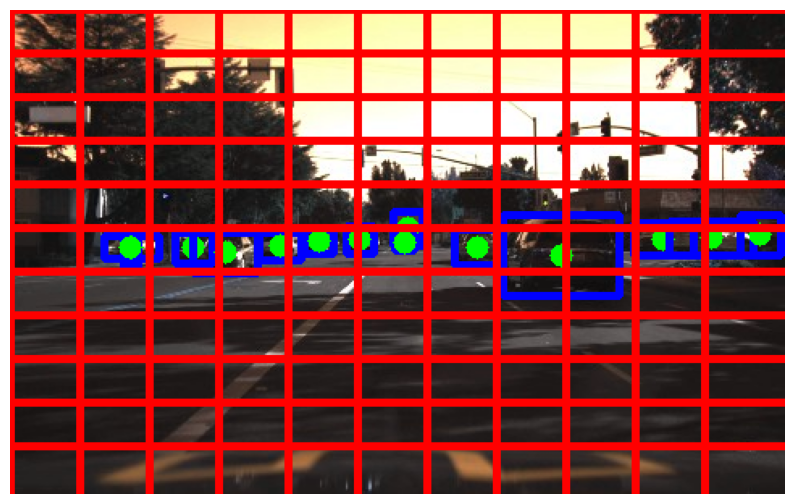

In [111]:
# Visualize the grid cells
draw_img = draw_grid(draw_img)
plt.figure(figsize=(10, 10))
plt.imshow(draw_img)
plt.axis('off')
plt.show()


# Data Preparation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0450819672131149].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.004098360655737705..1.0450819672131149].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.004098360655737705..1.0450819672131149].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.004098360655737705..1.0450819672131149].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0450819672131149].


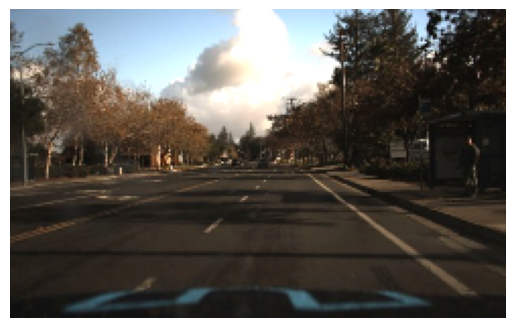

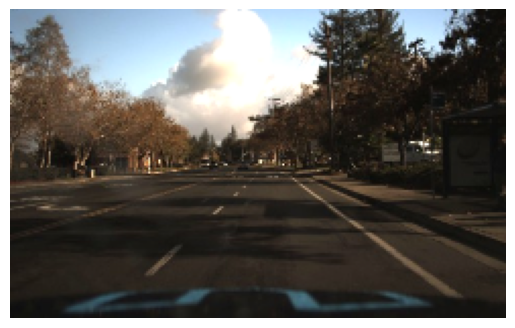

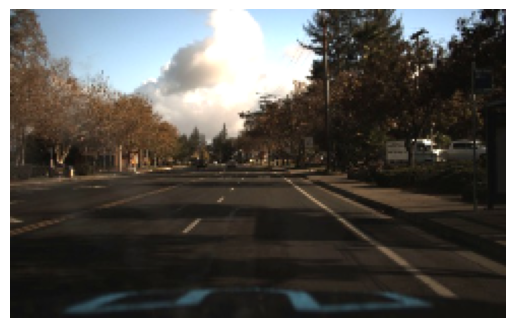

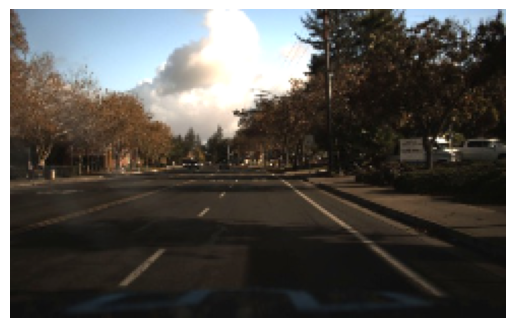

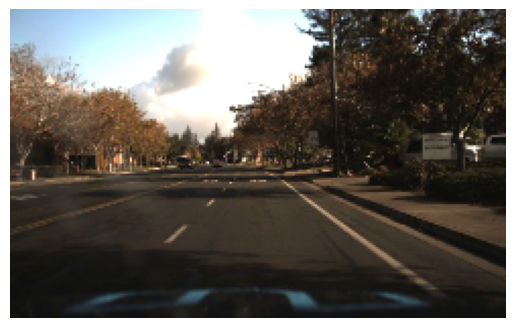

In [15]:
# function to resize the image
def resize_image(image, max_size=244):
    # Get the scale factor
    scale_factor = max_size / max(image.shape[0], image.shape[1])
    # Resize the image
    resized_image = cv2.resize(image, (0, 0), fx=scale_factor, fy=scale_factor)
    return resized_image

# function to convert the image to RGB
def convert_to_rgb(image):
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return rgb_image

# function to normalize the image
def normalize_image(image):
    normalized_image = image / 244.0
    return normalized_image

# function to add a dimension to the image
def add_dimension(image):
    expanded_image = np.expand_dims(image, 0)
    return expanded_image

# function to preprocess the images
def preprocess_images(images):
    preprocessed_images = []
    for image in images:
        resized_image = resize_image(image)
        rgb_image = convert_to_rgb(resized_image)
        normalized_image = normalize_image(rgb_image)
        expanded_image = add_dimension(normalized_image)
        preprocessed_images.append(expanded_image)
    return preprocessed_images

# take first 5 images and preprocess them
images = [cv2.imread(image_file) for image_file in image_files[:5]]

preprocessed_images = preprocess_images(images)

# display the preprocessed images
for image in preprocessed_images:
    plt.figure()
    plt.imshow(image[0])
    plt.axis('off')


In [16]:
# Shape of the preprocessed images
for image in preprocessed_images:
    print("The shape of the preprocessed image is: ", image.shape)

The shape of the preprocessed image is:  (1, 152, 244, 3)
The shape of the preprocessed image is:  (1, 152, 244, 3)
The shape of the preprocessed image is:  (1, 152, 244, 3)
The shape of the preprocessed image is:  (1, 152, 244, 3)
The shape of the preprocessed image is:  (1, 152, 244, 3)


In [18]:
# Save the preprocessed images to the preprocessed_images directory
preprocessed_images_directory = os.path.join(project_root, 'data', 'preprocessed_images')
if os.path.exists(preprocessed_images_directory):
    for file in os.listdir(preprocessed_images_directory):
        os.remove(os.path.join(preprocessed_images_directory, file))

# Create the preprocessed_images directory if it does not exist
create_directories(preprocessed_images_directory)

# Save the preprocessed images
images = [cv2.imread(image_file) for image_file in image_files]
for i, image in enumerate(images):
    preprocessed_image = preprocess_images([image])[0]
   # print(f"Saving preprocessed image {i}")
    cv2.imwrite(os.path.join(preprocessed_images_directory, f'image_{i}.jpg'), preprocessed_image[0] * 255.0)



Path is:  c:\Users\jegullin\Downloads\objectdetection-main\objectdetection-main\data\preprocessed_images


Image 1


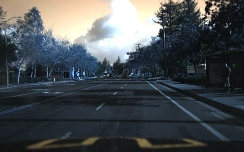


image 1/1 c:\Users\jegullin\Downloads\objectdetection-main\objectdetection-main\data\preprocessed_images\image_0.jpg: 416x640 1 person, 848.2ms
Speed: 2.0ms preprocess, 848.2ms inference, 2.6ms postprocess per image at shape (1, 3, 416, 640)
Image 1: person with confidence 0.32 at coordinates [221.78009033203125, 61.610992431640625, 231.14193725585938, 87.94849395751953]
Image 2


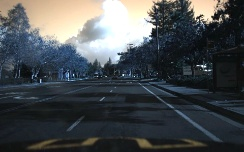


image 1/1 c:\Users\jegullin\Downloads\objectdetection-main\objectdetection-main\data\preprocessed_images\image_1.jpg: 416x640 (no detections), 842.9ms
Speed: 2.0ms preprocess, 842.9ms inference, 2.0ms postprocess per image at shape (1, 3, 416, 640)
Image 3


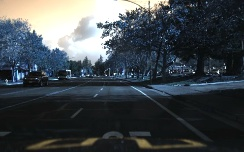


image 1/1 c:\Users\jegullin\Downloads\objectdetection-main\objectdetection-main\data\preprocessed_images\image_10.jpg: 416x640 1 car, 1 truck, 857.4ms
Speed: 2.2ms preprocess, 857.4ms inference, 2.0ms postprocess per image at shape (1, 3, 416, 640)
Image 3: car with confidence 0.48 at coordinates [22.70709991455078, 70.58160400390625, 48.4279899597168, 86.96074676513672]
Image 3: truck with confidence 0.43 at coordinates [22.683801651000977, 70.55782318115234, 48.47695541381836, 86.87976837158203]
Image 4


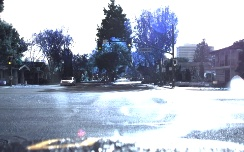


image 1/1 c:\Users\jegullin\Downloads\objectdetection-main\objectdetection-main\data\preprocessed_images\image_100.jpg: 416x640 1 car, 1 traffic light, 840.8ms
Speed: 2.0ms preprocess, 840.8ms inference, 3.0ms postprocess per image at shape (1, 3, 416, 640)
Image 4: car with confidence 0.45 at coordinates [59.687591552734375, 76.20655822753906, 75.68476867675781, 85.68777465820312]
Image 4: traffic light with confidence 0.29 at coordinates [173.00123596191406, 58.62648391723633, 176.59552001953125, 66.00822448730469]
Image 5


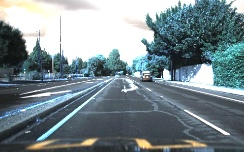


image 1/1 c:\Users\jegullin\Downloads\objectdetection-main\objectdetection-main\data\preprocessed_images\image_1000.jpg: 416x640 1 car, 1 truck, 817.3ms
Speed: 2.0ms preprocess, 817.3ms inference, 3.0ms postprocess per image at shape (1, 3, 416, 640)
Image 5: truck with confidence 0.38 at coordinates [140.00840759277344, 70.82440185546875, 152.59869384765625, 81.51971435546875]
Image 5: car with confidence 0.34 at coordinates [140.11190795898438, 72.45757293701172, 152.75021362304688, 81.60126495361328]
[{'label': 'person', 'confidence': 0.32, 'coordinates': [221.78009033203125, 61.610992431640625, 231.14193725585938, 87.94849395751953], 'image': 'c:\\Users\\jegullin\\Downloads\\objectdetection-main\\objectdetection-main\\data\\preprocessed_images\\image_0.jpg'}, {'label': 'car', 'confidence': 0.48, 'coordinates': [22.70709991455078, 70.58160400390625, 48.4279899597168, 86.96074676513672], 'image': 'c:\\Users\\jegullin\\Downloads\\objectdetection-main\\objectdetection-main\\data\\prep

In [19]:

preprocessed_image_files = glob(os.path.join(preprocessed_images_directory, '*.jpg'))

# Take the first 5 preprocessed images
preprocessed_image_files = preprocessed_image_files[:5]

# Run model for all the preprocessed images
identified_objects = []
image_name = []
for i, preprocessed_image_file in enumerate(preprocessed_image_files):
    # Display the image number and image
    print(f"Image {i+1}")
    img = Image.open(preprocessed_image_file)
    display(img)
    yolo_outputs = yolo_model.predict(preprocessed_image_file)
    output = yolo_outputs[0]
    box = output.boxes
    names = output.names
    for j in range(len(box)):
        labels = names[box.cls[j].item()]
        coordinates = box.xyxy[j].tolist()
        confidence = np.round(box.conf[j].item(), 2)
        print(f"Image {i+1}: {labels} with confidence {confidence} at coordinates {coordinates}")
        identified_objects.append({'label': labels, 'confidence': confidence, 'coordinates': coordinates, 'image': preprocessed_image_file})
        image_name.append(preprocessed_image_file)

# Display the dictionary
print(identified_objects)
